In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
from PIL import Image
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, AveragePooling2D

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
import time
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


#  Introduction, Data Description



The goal of this competition is to create an algorithm that can detect cancerous tissue in scans of lymph node sections. The algorithm should be able to correctly classify 57,458 test images as either "malignant" (cancerous) or "normal." An image is considered "malignant" if it contains at least one pixel of tumor tissue in the center 32x32px of the image. Kaggle provides a training dataset with 220,025 labeled images (malignant or normal) to help. Both the training and test data come from the PatchCamelyon (PCam) benchmark dataset, but the Kaggle version does not include duplicate images, unlike the original PCam dataset

In [8]:
train_folder = '/kaggle/input/histopathologic-cancer-detection/train/'
test_folder = '/kaggle/input/histopathologic-cancer-detection/test/'
sample_submission = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
train_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

In [9]:
display(sample_submission.head(10))
display(train_labels.head(10))

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0
6,aa0307865281d4484ddf8c637c348292968b93a7,0
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


# Exploratory Data Analysis (EDA)

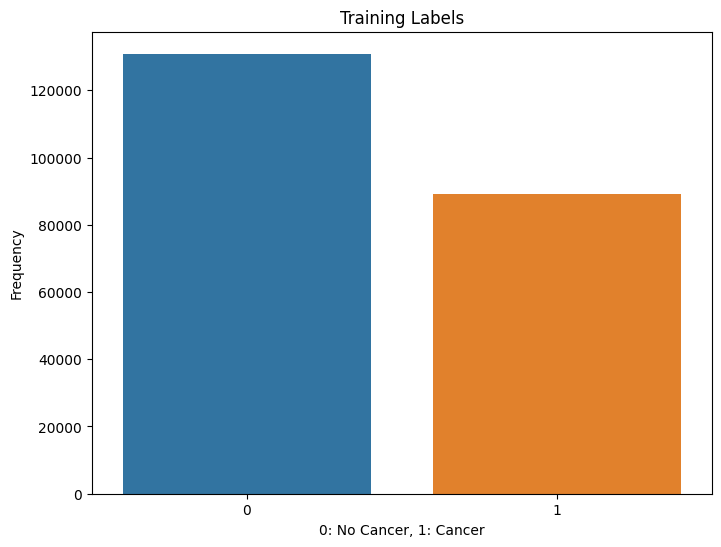

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Training Labels')
plt.xlabel('0: No Cancer, 1: Cancer')
plt.ylabel('Frequency')
plt.show()

**Show 8 samples with cancer and 8 without cancer**

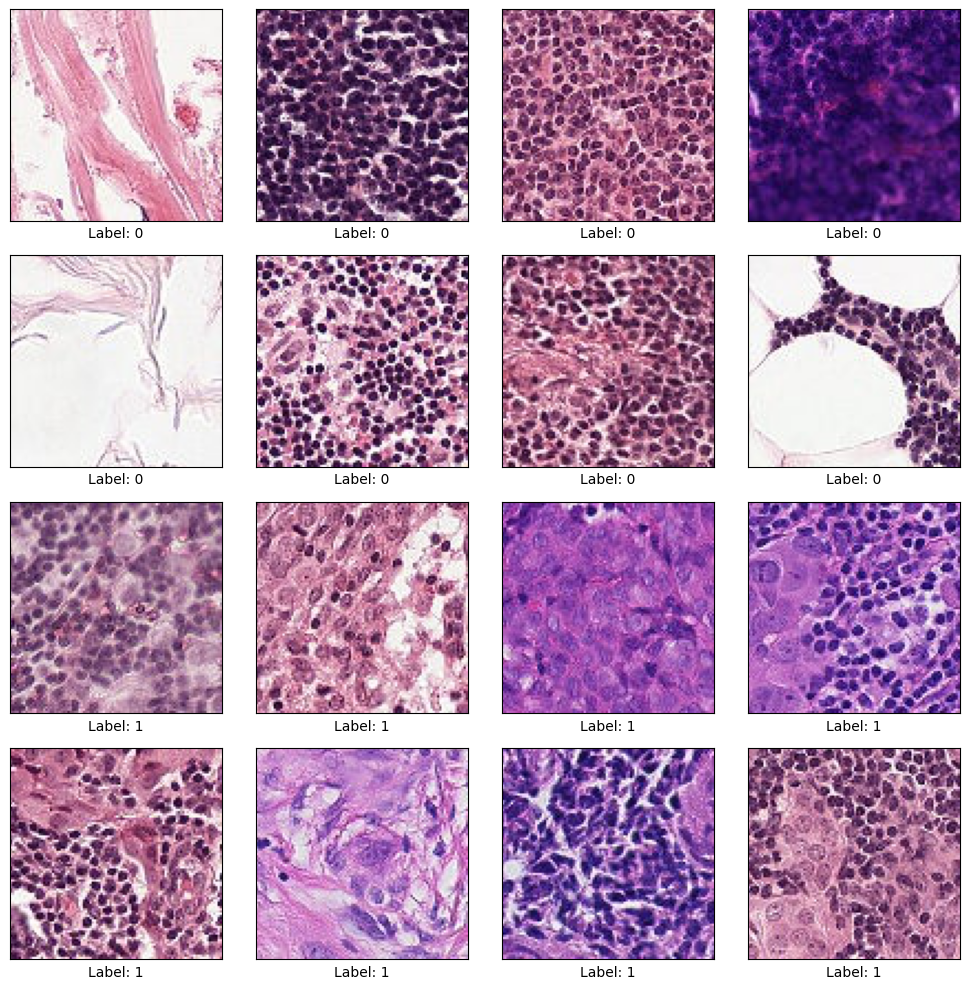

In [11]:
label_0 = train_labels[train_labels.label == 0].sample(8, random_state=42)
label_1 = train_labels[train_labels.label == 1].sample(8, random_state=42)

selected_images = pd.concat([label_0, label_1]).reset_index(drop=True)
fig, ax = plt.subplots(4, 4, figsize=(10, 10))

for i, axis in enumerate(ax.flat):
    file = str(train_folder + selected_images.id.iloc[i] + '.tif')
    image = Image.open(file)
    axis.imshow(image)
    axis.set(xticks=[], yticks=[], xlabel=f"Label: {selected_images.label.iloc[i]}")
plt.tight_layout()
plt.show()

**Proper extension for images below. Also conversion of labels to string.**

In [12]:
def append_tif(string):
    return string+".tif"
    
train_labels["id"] = train_labels["id"].apply(append_tif)
train_labels['label'] = train_labels['label'].astype(str)

In [13]:
class TimeCallback(Callback):    
    def on_train_begin(self, logs=None):
        print("Training is starting...")

In [14]:
# train_labels = shuffle(train_labels, random_state=49).head(100)
train_labels = shuffle(train_labels, random_state=49)

**Confirm tif extension and labels working as expected**

In [15]:
print(train_labels.head())
print(train_labels.columns)
print(train_labels.dtypes)

                                                  id label
92002   9b1f3082f427b7f76e711295de2806060a223dd9.tif     0
137370  8e871edc0d02ebc470dbdcffa502ac52e0c6d29e.tif     0
119572  b2c9725c73d290b0e7aa22f89369e3f757581483.tif     0
16082   da09fb7690e0b509db6d595cd101f9146895069a.tif     1
217979  da1bfd1ef81aea0a1cc574039c7a7d3eeb1fc8c6.tif     0
Index(['id', 'label'], dtype='object')
id       object
label    object
dtype: object


# DModel Architecture

Preprocess and saving images needed to be done once and not for every model. This was very time consuming when run per model. Preprocess resizes images and normalizes the pixel values. Progress tracking was also added given how long the process takes. 

ImageDataGenerator is used to apply shifting, flipping, and data set management with train and validation

The logic behind the different models was starting simple with a baseline. Next models would add more conv layers, dropout layers, then max pooling layers separately. The final addition was the base model with more depth.

Early stopping was used and helpful in reducing the runtime. I removed early stopping to see the impact of more epochs on the variations of models in relation to train and validation accuracy.

In [16]:
def preprocess_and_save_images(train_labels, train_folder, target_size=(32, 32)):
    """Preload images, resize them, and store them in a NumPy array for faster access."""
    images = []
    labels = []
    
    for _, row in tqdm(train_labels.iterrows(), total=len(train_labels), desc="Preprocessing Images"):
        img_path = os.path.join(train_folder, row["id"])
        img = cv2.imread(img_path)
        
        if img is None:
            continue
        
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0

        images.append(img)
        labels.append(row["label"])

    return np.array(images), np.array(labels)

# BASE MODEL
def create_base_model(optimizer='adam', learning_rate=0.001, loss='binary_crossentropy', metrics=['accuracy']):
    model = Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# MORE CONV LAYERS
def create_conv_layers_model(optimizer='adam', learning_rate=0.001, loss='binary_crossentropy', metrics=['accuracy']):
    model = Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# MAX POOLING MODEL
def create_max_pool_model(optimizer='adam', learning_rate=0.001, loss='binary_crossentropy', metrics=['accuracy']):
    model = Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2), strides=(2, 2)),  # Added max pooling layer
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# DROPOUT MODEL
def create_dropout_model(optimizer='adam', learning_rate=0.001, loss='binary_crossentropy', metrics=['accuracy']):
    model = Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.25),  # Added dropout layer
        Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# MORE DEPTH BASE
def create_base_depth_model(optimizer='adam', learning_rate=0.001, loss='binary_crossentropy', metrics=['accuracy']):
    model = Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(32, (3, 3), activation='relu'),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def create_data_generators(train_images, train_labels, batch_size=64):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        vertical_flip=True,
        horizontal_flip=True,
        width_shift_range=0.05,
        height_shift_range=0.05
    )

    train_generator = datagen.flow(
        train_images, train_labels,
        batch_size=batch_size,
        subset="training"
    )

    validation_generator = datagen.flow(
        train_images, train_labels,
        batch_size=batch_size,
        subset="validation"
    )

    return train_generator, validation_generator

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def train_model(model, train_generator, validation_generator, epochs=10):
    """Train a model using the preloaded data generators."""
    history = model.fit(
        train_generator, 
        epochs=epochs, 
        validation_data=validation_generator, 
        # callbacks=[early_stopping],
        verbose=1,
    )
    return history

In [17]:
from tqdm import tqdm
import cv2


train_images, train_labels = preprocess_and_save_images(train_labels, train_folder, target_size=(32, 32))
np.save('/kaggle/working/train_images.npy', train_images)
np.save('/kaggle/working/train_labels.npy', train_labels)
# train_images = np.load('/kaggle/input/train_data/train_images.npy')
# train_labels = np.load('/kaggle/input/train_data/train_labels.npy')

# Convert labels to float (ensure compatibility with generator)
train_labels = train_labels.astype(np.float32)
# Create data generators ONCE
train_generator, validation_generator = create_data_generators(train_images, train_labels, batch_size=64)

base_model = create_base_model(optimizer='adam', learning_rate=0.001)
base_model_history = train_model(base_model, train_generator, validation_generator, epochs=10)

conv_layers_model = create_conv_layers_model(optimizer='adam', learning_rate=0.01)
conv_layers_history = train_model(conv_layers_model, train_generator, validation_generator, epochs=10)

max_pool_model = create_max_pool_model(optimizer='adam', learning_rate=0.001)
max_pool_history = train_model(max_pool_model, train_generator, validation_generator, epochs=10)

dropout_model = create_dropout_model(optimizer='adam', learning_rate=0.001)
dropout_model_history = train_model(base_model, train_generator, validation_generator, epochs=10)

base_depth_model = create_base_depth_model(optimizer='adam', learning_rate=0.001)
base_depth_model_history = train_model(base_depth_model, train_generator, validation_generator, epochs=10)

models = [base_model, conv_layers_model, max_pool_model, dropout_model, base_depth_model]
histories = [base_model_history, conv_layers_history, max_pool_history, dropout_model_history, base_depth_model_history]

Preprocessing Images: 100%|██████████| 220025/220025 [38:46<00:00, 94.59it/s] 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         921,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 922,561 (3.52 MB)

 Trainable params: 922,561 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 147s 55ms/step - accuracy: 0.5897 - loss: 0.6861 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 2/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 138s 53ms/step - accuracy: 0.5951 - loss: 0.6751 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 3/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 137s 53ms/step - accuracy: 0.5969 - loss: 0.6742 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 4/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 142s 55ms/step - accuracy: 0.5929 - loss: 0.6758 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 5/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 138s 53ms/step - accuracy: 0.5934 - loss: 0.6760 - val_accuracy: 0.5947 - val_loss: 0.6752
Epoch 6/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 140s 54ms/step - accuracy: 0.5957 - loss: 0.6748 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 7/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 136s 53ms/step - accuracy: 0.5948 - loss: 0.6751 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 8/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 135s 52ms/step - accuracy: 0.5952 - lo

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,688,321 (14.07 MB)

 Trainable params: 3,688,321 (14.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 143s 55ms/step - accuracy: 0.7121 - loss: 0.5858 - val_accuracy: 0.7541 - val_loss: 0.5160
Epoch 2/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - accuracy: 0.7507 - loss: 0.5151 - val_accuracy: 0.7609 - val_loss: 0.4983
Epoch 3/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - accuracy: 0.7599 - loss: 0.5023 - val_accuracy: 0.7713 - val_loss: 0.4845
Epoch 4/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 147s 57ms/step - accuracy: 0.7688 - loss: 0.4885 - val_accuracy: 0.7680 - val_loss: 0.4903
Epoch 5/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 145s 56ms/step - accuracy: 0.7742 - loss: 0.4799 - val_accuracy: 0.7813 - val_loss: 0.4821
Epoch 6/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - accuracy: 0.7783 - loss: 0.4735 - val_accuracy: 0.7814 - val_loss: 0.4708
Epoch 7/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - accuracy: 0.7810 - loss: 0.4710 - val_accuracy: 0.7808 - val_loss: 0.4703
Epoch 8/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 140s 54ms/step - accuracy: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │         230,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,361 (903.75 KB)

 Trainable params: 231,361 (903.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 140s 54ms/step - accuracy: 0.7038 - loss: 0.5802 - val_accuracy: 0.7507 - val_loss: 0.5204
Epoch 2/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 143s 55ms/step - accuracy: 0.7597 - loss: 0.5057 - val_accuracy: 0.7694 - val_loss: 0.4891
Epoch 3/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 138s 53ms/step - accuracy: 0.7651 - loss: 0.4922 - val_accuracy: 0.7803 - val_loss: 0.4722
Epoch 4/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 136s 53ms/step - accuracy: 0.7756 - loss: 0.4759 - val_accuracy: 0.7824 - val_loss: 0.4660
Epoch 5/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 136s 52ms/step - accuracy: 0.7798 - loss: 0.4681 - val_accuracy: 0.7873 - val_loss: 0.4603
Epoch 6/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 131s 51ms/step - accuracy: 0.7845 - loss: 0.4599 - val_accuracy: 0.7933 - val_loss: 0.4451
Epoch 7/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 132s 51ms/step - accuracy: 0.7869 - loss: 0.4535 - val_accuracy: 0.7986 - val_loss: 0.4389
Epoch 8/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 130s 50ms/step - accuracy: 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │         921,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 922,561 (3.52 MB)

 Trainable params: 922,561 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 142s 55ms/step - accuracy: 0.5956 - loss: 0.6748 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 2/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - accuracy: 0.5956 - loss: 0.6748 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 3/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - accuracy: 0.5951 - loss: 0.6750 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 4/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 143s 55ms/step - accuracy: 0.5961 - loss: 0.6746 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 5/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - accuracy: 0.5946 - loss: 0.6752 - val_accuracy: 0.5947 - val_loss: 0.6752
Epoch 6/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 143s 55ms/step - accuracy: 0.5944 - loss: 0.6752 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 7/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 132s 51ms/step - accuracy: 0.5957 - loss: 0.6747 - val_accuracy: 0.5947 - val_loss: 0.6751
Epoch 8/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 131s 51ms/step - accuracy: 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │         802,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 814,081 (3.11 MB)

 Trainable params: 814,081 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 143s 54ms/step - accuracy: 0.7295 - loss: 0.5394 - val_accuracy: 0.7752 - val_loss: 0.4827
Epoch 2/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 135s 52ms/step - accuracy: 0.7795 - loss: 0.4703 - val_accuracy: 0.7894 - val_loss: 0.4550
Epoch 3/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 135s 52ms/step - accuracy: 0.7876 - loss: 0.4567 - val_accuracy: 0.7806 - val_loss: 0.4675
Epoch 4/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 133s 51ms/step - accuracy: 0.7951 - loss: 0.4436 - val_accuracy: 0.7863 - val_loss: 0.4563
Epoch 5/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 133s 51ms/step - accuracy: 0.8005 - loss: 0.4324 - val_accuracy: 0.7905 - val_loss: 0.4481
Epoch 6/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 131s 51ms/step - accuracy: 0.8071 - loss: 0.4203 - val_accuracy: 0.8194 - val_loss: 0.4018
Epoch 7/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 128s 50ms/step - accuracy: 0.8137 - loss: 0.4117 - val_accuracy: 0.8191 - val_loss: 0.4036
Epoch 8/10
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 131s 51ms/step - accuracy: 

# Results and Analysis

The base model with more depth had the best validation accuracy. Adding max pool layers and convolutional layers were next best for validation accuracy. The baseline model and drop out layer model with were worst in terms of validation accuracy.

Overfitting was not a concern in this problem which is why the drop out layer did not do much.

The base model and drop out model produced nearly identical metrics. Over more epochs the metrics for both did not change. 

Troubleshooting involved saving variables locally to avoid having to rerun from the beginning in the case of Kaggle freezing up, this happened many times. The hyperparams of learning rate was somewhat consistent, but the epochs was a learning experience. Increasing epochs did not lead to increased accuracy in results. 


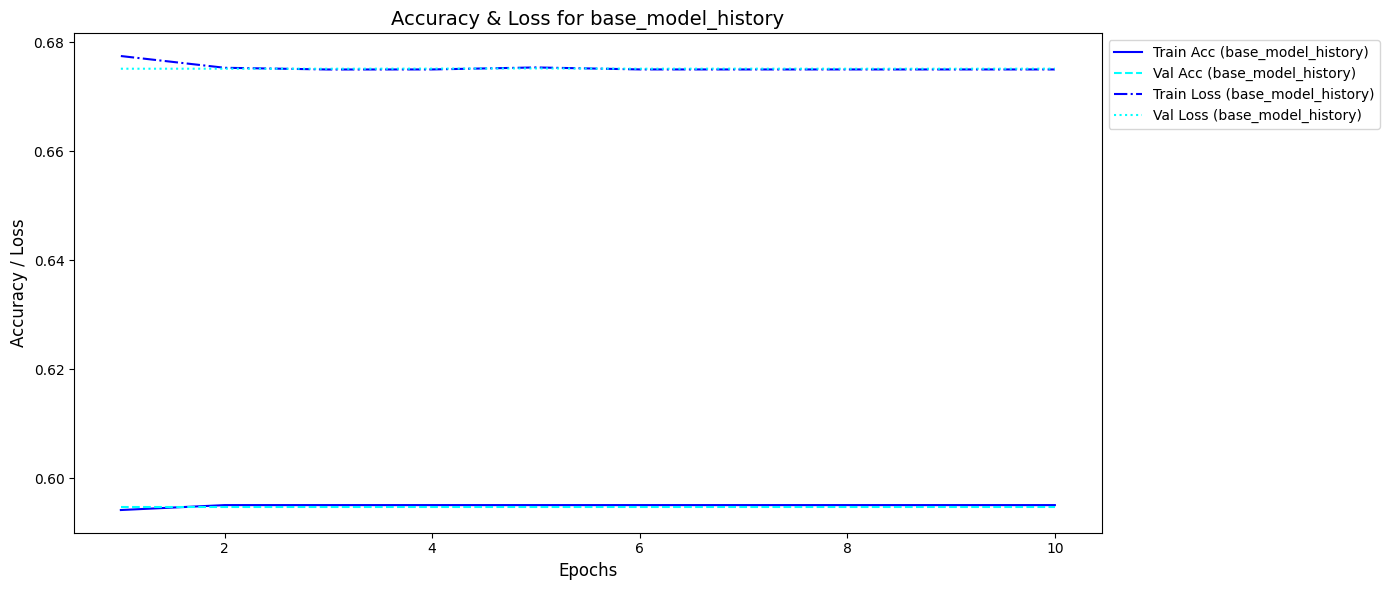

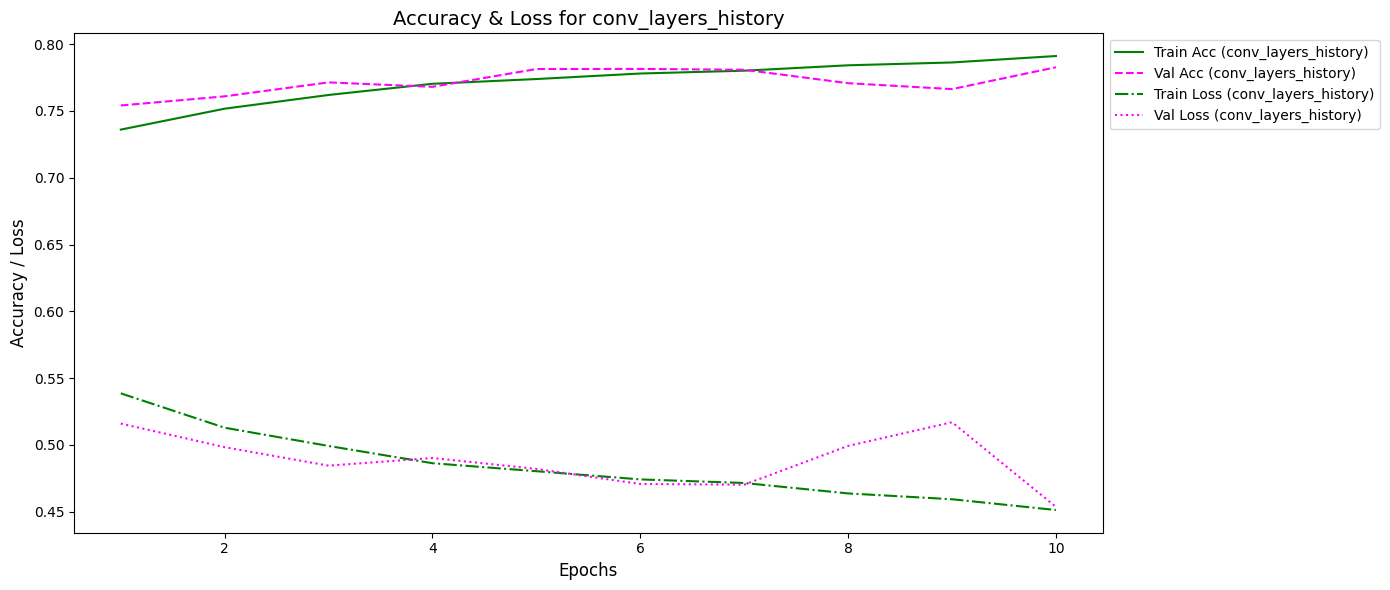

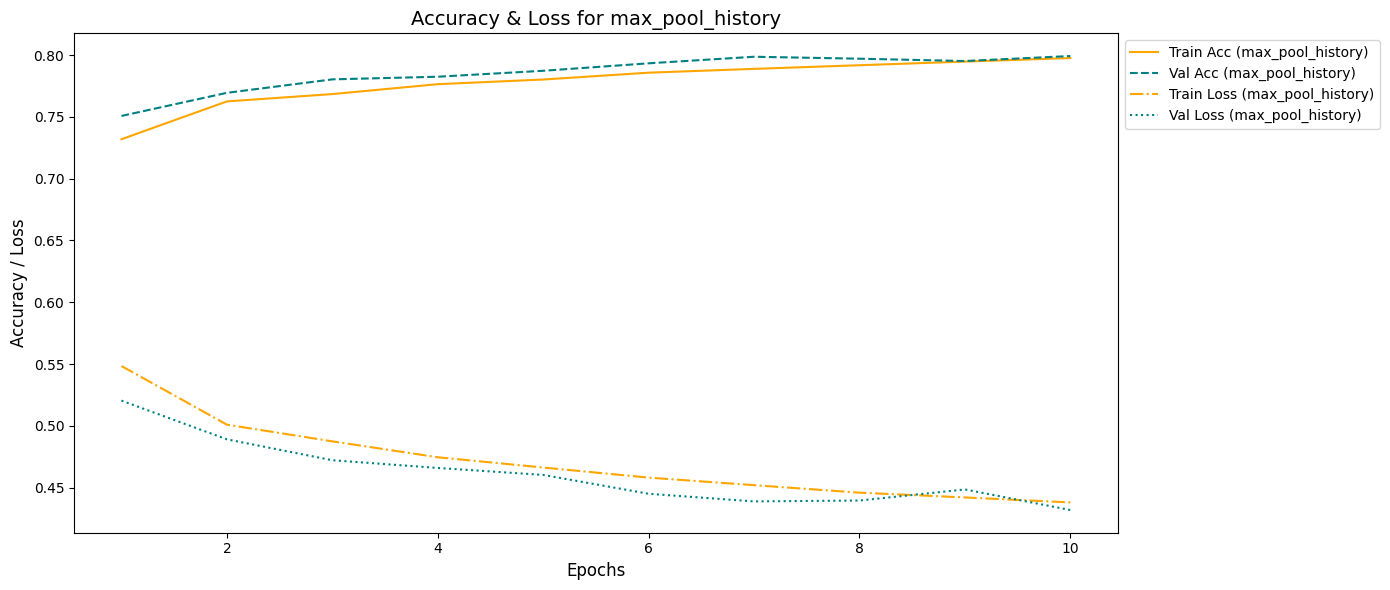

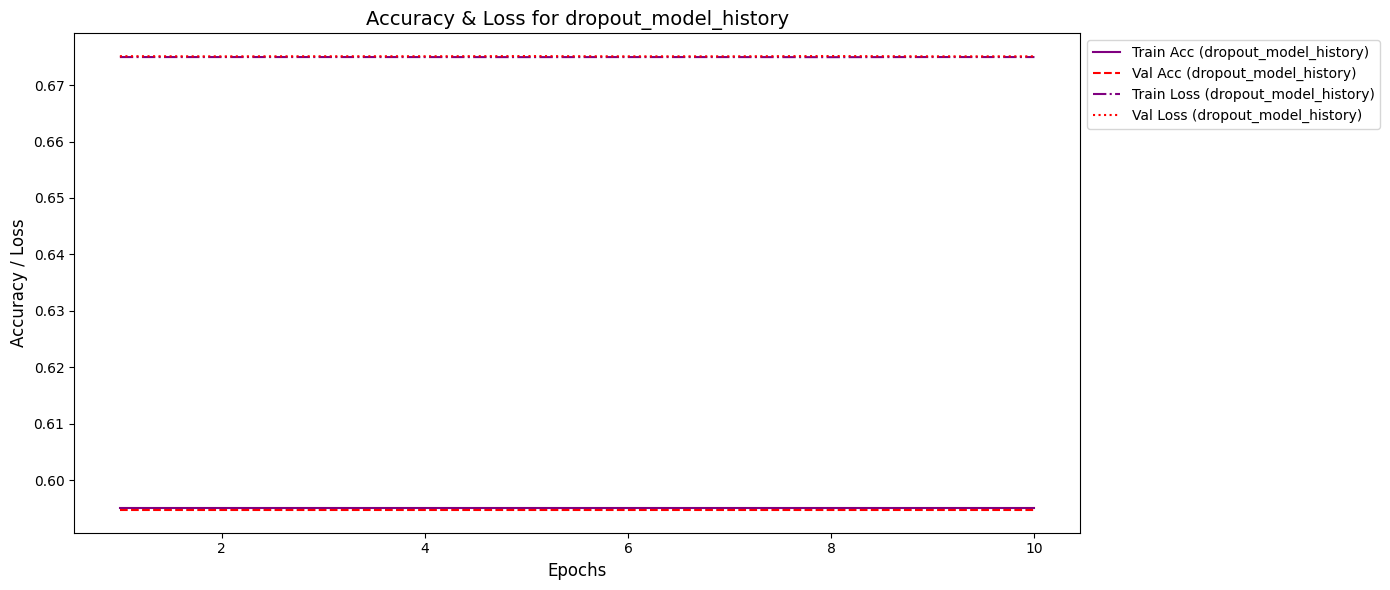

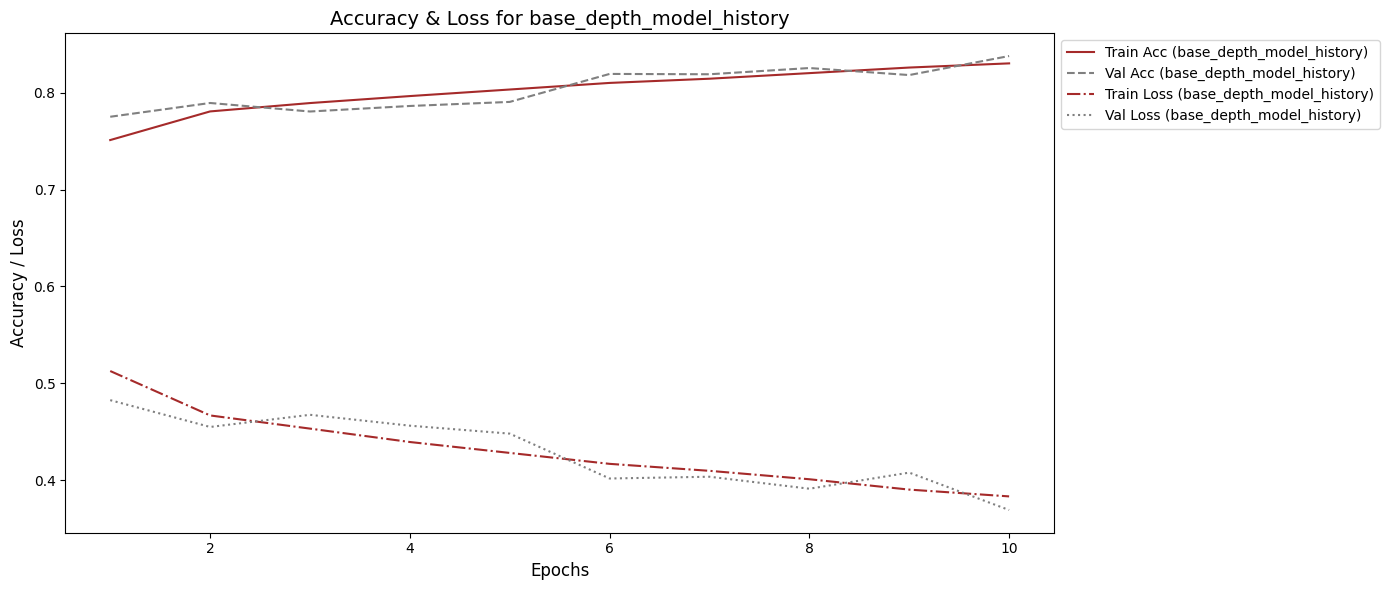

In [40]:
train_colors = ['blue', 'green', 'orange', 'purple', 'brown']
val_colors = ['cyan', 'magenta', 'teal', 'red', 'gray']

models = {
    'base_model_history': base_model_history,
    'conv_layers_history': conv_layers_history,
    'max_pool_history': max_pool_history,
    'dropout_model_history': dropout_model_history,
    'base_depth_model_history': base_depth_model_history,
}

for i, (model_name, history) in enumerate(models.items()):
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.plot(range(1, len(history.history['accuracy']) + 1),
            history.history['accuracy'],
            label=f'Train Acc ({model_name})', color=train_colors[i], linestyle='-')
    ax.plot(range(1, len(history.history['val_accuracy']) + 1),
            history.history['val_accuracy'],
            label=f'Val Acc ({model_name})', color=val_colors[i], linestyle='--')
    ax.plot(range(1, len(history.history['loss']) + 1),
            history.history['loss'],
            label=f'Train Loss ({model_name})', color=train_colors[i], linestyle='-.')
    ax.plot(range(1, len(history.history['val_loss']) + 1),
            history.history['val_loss'],
            label=f'Val Loss ({model_name})', color=val_colors[i], linestyle=':')

    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Accuracy / Loss', fontsize=12)
    ax.set_title(f'Accuracy & Loss for {model_name}', fontsize=14)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    plt.tight_layout()
    plt.show()

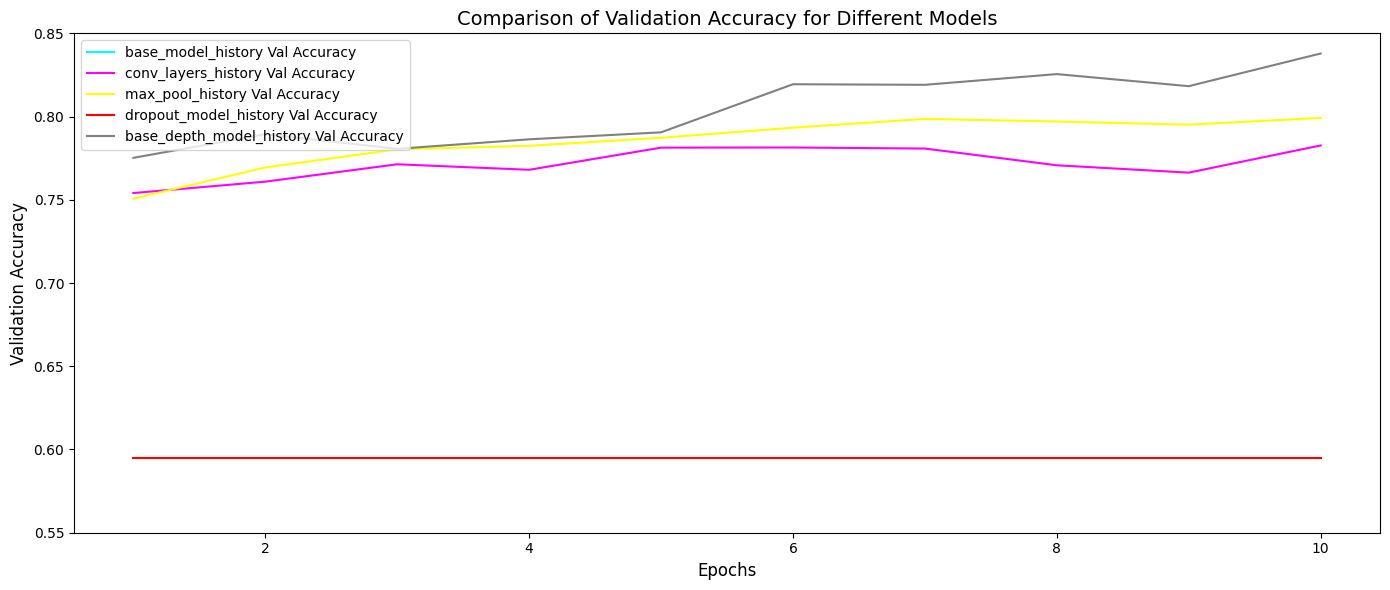

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))

for i, (model_name, history) in enumerate(models.items()):
    ax.plot(range(1, len(history.history['val_accuracy']) + 1),
            history.history['val_accuracy'],
            label=f'{model_name} Val Accuracy', color=val_colors[i])

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Comparison of Validation Accuracy for Different Models', fontsize=14)

ax.set_ylim(0.55, 0.85)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

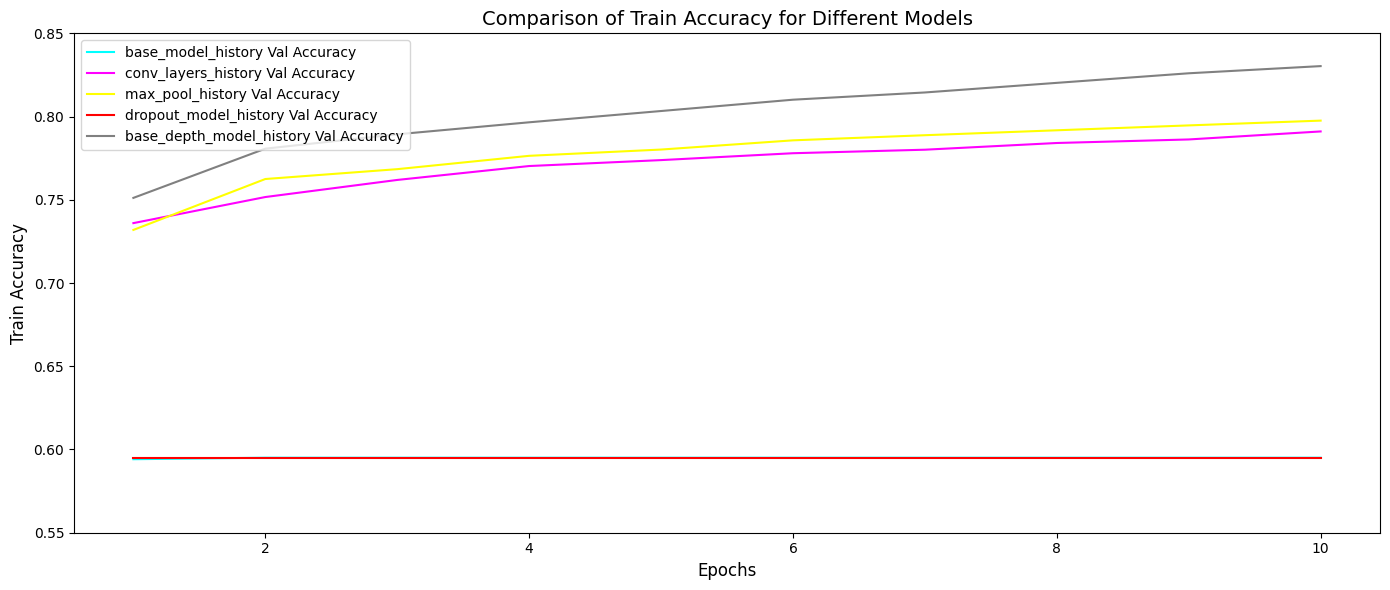

In [37]:
fig, ax = plt.subplots(figsize=(14, 6))

for i, (model_name, history) in enumerate(models.items()):
    ax.plot(range(1, len(history.history['accuracy']) + 1),
            history.history['accuracy'],
            label=f'{model_name} Val Accuracy', color=val_colors[i])

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Train Accuracy', fontsize=12)
ax.set_title('Comparison of Train Accuracy for Different Models', fontsize=14)

ax.set_ylim(0.55, 0.85)
ax.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


In [20]:
test_df = pd.DataFrame({'id': os.listdir(test_folder)})
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_folder,
    x_col='id',
    y_col=None,
    target_size=(32, 32),
    batch_size=64,
    shuffle=False,
    class_mode=None
)

predictions = []

for batch in tqdm(test_generator, total=test_generator.samples // test_generator.batch_size, desc="Predicting"):
    batch_preds = base_model.predict(batch, verbose=0)
    predictions.append(batch_preds)

predictions = np.concatenate(predictions, axis=0).flatten()

submission_df = pd.DataFrame({
    'id': test_df['id'].apply(lambda x: x.split('.')[0]),
    'label': (predictions >= 0.5).astype(int)
})


print(submission_df['label'].value_counts())
submission_df.to_csv('submission.csv', index=False)

# Conclusion

The deepest base model achieved the best results. Certain layers like dropout were not impactful given the data was too complex for my model to experience. Knowing when to utilize depth versus width in layers is important. 

In the future I would consider steps for improving runtime. How to process images and parallel processing were not an initial priority but with complex data like images and the volume of data it became a burden. It would also be worth starting with a base model that is more complex given the problem at hand. Adjusting the hyperparams and layers according to the type of data is much easier than guess and check which I unfortunately did initially.